# 5 Matrix Factorization Visualizations

In [2]:
# Setup
import utils
import matrix_factorization as mf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'
sns.set()
sns.set_style("white")

In [4]:
Y_train = utils.get_training_data()
Y_test = utils.get_test_data()
Y = utils.get_data()
movie_id, movie_title, movie_genre, genres = utils.get_movies()
genre_similarity = utils.genre_similarity(movie_genre)

M = 943 # users
N = 1682 # movies
K = 20
reg = 0.1
eta = 0.03

## 1. Simple SGD from Homework

In [5]:
U_simple, V_simple, err_simple = mf.train_model(Y_train, M, N, K, eta, reg)
err_test_simple = mf.get_err(U_simple, V_simple, Y_test)
err_test_simple /= Y_test.shape[0]

Epoch  0: current average training error 0.506
Epoch  1: current average training error 0.435
Epoch  2: current average training error 0.416
Epoch  3: current average training error 0.395
Epoch  4: current average training error 0.379
Epoch  5: current average training error 0.373
Epoch  6: current average training error 0.363
Epoch  7: current average training error 0.355
Epoch  8: current average training error 0.346
Epoch  9: current average training error 0.339
Epoch 10: current average training error 0.332
Epoch 11: current average training error 0.327
Epoch 12: current average training error 0.323
Epoch 13: current average training error 0.316
Epoch 14: current average training error 0.314
Epoch 15: current average training error 0.311
Epoch 16: current average training error 0.309
Epoch 17: current average training error 0.301
Epoch 18: current average training error 0.301


## 2. Incorporating a Bias Term

In [7]:
U_bias, V_bias, biases, err_bias = mf.train_model(Y_train, M, N, K, eta, reg, include_bias=True)
err_test_bias = mf.get_err(U_bias, V_bias, Y_test, biases=biases)
err_test_bias /= Y_test.shape[0]

Epoch  0: current average training error 0.441
Epoch  1: current average training error 0.411
Epoch  2: current average training error 0.398
Epoch  3: current average training error 0.387
Epoch  4: current average training error 0.375
Epoch  5: current average training error 0.363
Epoch  6: current average training error 0.354
Epoch  7: current average training error 0.348
Epoch  8: current average training error 0.337
Epoch  9: current average training error 0.329
Epoch 10: current average training error 0.322
Epoch 11: current average training error 0.317
Epoch 12: current average training error 0.310
Epoch 13: current average training error 0.305
Epoch 14: current average training error 0.302
Epoch 15: current average training error 0.299
Epoch 16: current average training error 0.295
Epoch 17: current average training error 0.292
Epoch 18: current average training error 0.289
Epoch 19: current average training error 0.286
Epoch 20: current average training error 0.284
Epoch 21: cur

## Off-the-shelf solution

In [8]:
import surprise
from surprise import accuracy
from surprise import SVD
from surprise import Reader
from surprise import Dataset

pkf = surprise.model_selection.PredefinedKFold()
reader = Reader(rating_scale=(1, 5))

fulldata = Dataset.load_from_folds([("data/train.txt","data/test.txt")],reader)

surprise_SVD = SVD(n_factors = 20, n_epochs = 30, biased = True)

for trainset, testset in pkf.split(fulldata):

    # train and test algorithm.
    surprise_SVD.fit(trainset)
    predictions = surprise_SVD.test(testset)

    # Compute and print Root Mean Squared Error
    surprise_error = accuracy.rmse(predictions, verbose=True)
    

RMSE: 0.9286


In [13]:
accuracies = pd.DataFrame(columns=["Error"])
accuracies = accuracies.append(pd.Series([err_test_simple], name="Simple SVD", index=["Error"]))
accuracies = accuracies.append(pd.Series([err_test_bias], name="Biased SVD", index=["Error"]))
accuracies = accuracies.append(pd.Series([surprise_error], name="Surprise", index=["Error"]))
accuracies

,Error
Simple SVD,0.452937
Biased SVD,0.429117
Surprise,0.926644


## Visualization

### Movie projections

In [42]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.layouts import row

def get_SVD_movie_projection(V):
    
     # SVD for the latent factor of the movies
    A, _, _ = np.linalg.svd(V)
    
    V_transformed = np.multiply(A[0:1, :].T, V)
    
    return V_transformed

def get_movie_projection_plot(V, title, size=300):
    
    plot = figure(plot_width=size, plot_height=size, title=title)
    plot.circle(V[0, :], V[1, :])
    plot.xaxis.axis_label = "1"
    plot.yaxis.axis_label = "2"
    plot.toolbar_location = None
    
    return plot

V_simple_transformed = get_SVD_movie_projection(V_simple)
V_bias_transformed = get_SVD_movie_projection(V_bias)
V_surprise_transformed = surprise_SVD.pu[:, 0:2].T

simple_SVD_projection_plot = get_movie_projection_plot(V_simple_transformed, "Simple Movie SVD Projection")
bias_SVD_projection_plot = get_movie_projection_plot(V_bias_transformed, "Biased Movie SVD Projection")
off_the_shelf_projection_plot = get_movie_projection_plot(V_surprise_transformed, "Surprise Movie SVD Projection")
output_notebook()
show(row([simple_SVD_projection_plot, bias_SVD_projection_plot, off_the_shelf_projection_plot]))

Loading BokehJS ...

## a) Visualizing 10 Movies

In [134]:
movies_of_interest = [
    "\"Aristocats, The (1970)\"", "\"Fox and the Hound, The (1981)\"", "Major Payne (1994)", "Toy Story (1995)", "Dunston Checks In (1996)",
    "Taxi Driver (1976)", "\"Boot, Das (1981)\"", "Brazil (1985)", "Schindler's List (1993)", "Alien: Resurrection (1997)"
]

movies_of_interest_ids = []

for movie_of_interest in movies_of_interest:
    movie_index = list(movie_title).index(movie_of_interest)#np.where(movie_title == movie_of_interest)[0]
    movies_of_interest_ids.append(movie_index)

from bokeh.models import ColumnDataSource, Range1d, LabelSet, Label

def get_custom_movie_projection_plot(coordinates, movie_titles, title, size=450):
    
    x_range = max(coordinates[0, :]) - min(coordinates[0, :])
    x_min = min(coordinates[0, :]) - x_range * 0.5
    x_max = max(coordinates[0, :]) + x_range * 0.5
    
    plot = figure(plot_width=size, plot_height=size, title=title, x_range=(x_min, x_max))
    plot.circle(coordinates[0, :], coordinates[1, :])
    plot.xaxis.axis_label = "1"
    plot.yaxis.axis_label = "2"
    source = ColumnDataSource(data=dict(dim1=coordinates[0, :],
                                        dim2=coordinates[1, :],
                                        names=movie_titles))

    plot.scatter(x='dim1', y='dim2', size=8, source=source)

    labels = LabelSet(x='dim1', y='dim2', text='names', level='glyph',
                  x_offset=5, y_offset=5, source=source, render_mode='canvas')
    plot.add_layout(labels)
    
    return plot

simple_SVD_custom_movie_plot = get_custom_movie_projection_plot(V_simple_transformed[:, movies_of_interest_ids], movies_of_interest, "Simple Movie SVD Projection", size=800)
show(simple_SVD_custom_movie_plot)

In [135]:
bias_SVD_custom_movie_plot = get_custom_movie_projection_plot(V_bias_transformed[:, movies_of_interest_ids], movies_of_interest, "Biased Movie SVD Projection", size=800)
show(bias_SVD_custom_movie_plot)

## b) Most popular movies

In [62]:
YM = utils.list_to_matrix(Y, M, N)
counts, ratings, ratings_bayesian = utils.bayesian_rating(Y, thr=4)
rank_counts = np.argsort(-counts) # Indices of counts in descending order
rank_ratings = np.argsort(-ratings) # Indices of ratings in descending order
rank_ratings_bayesian = np.argsort(-ratings_bayesian) # Indices of ratings in descending order

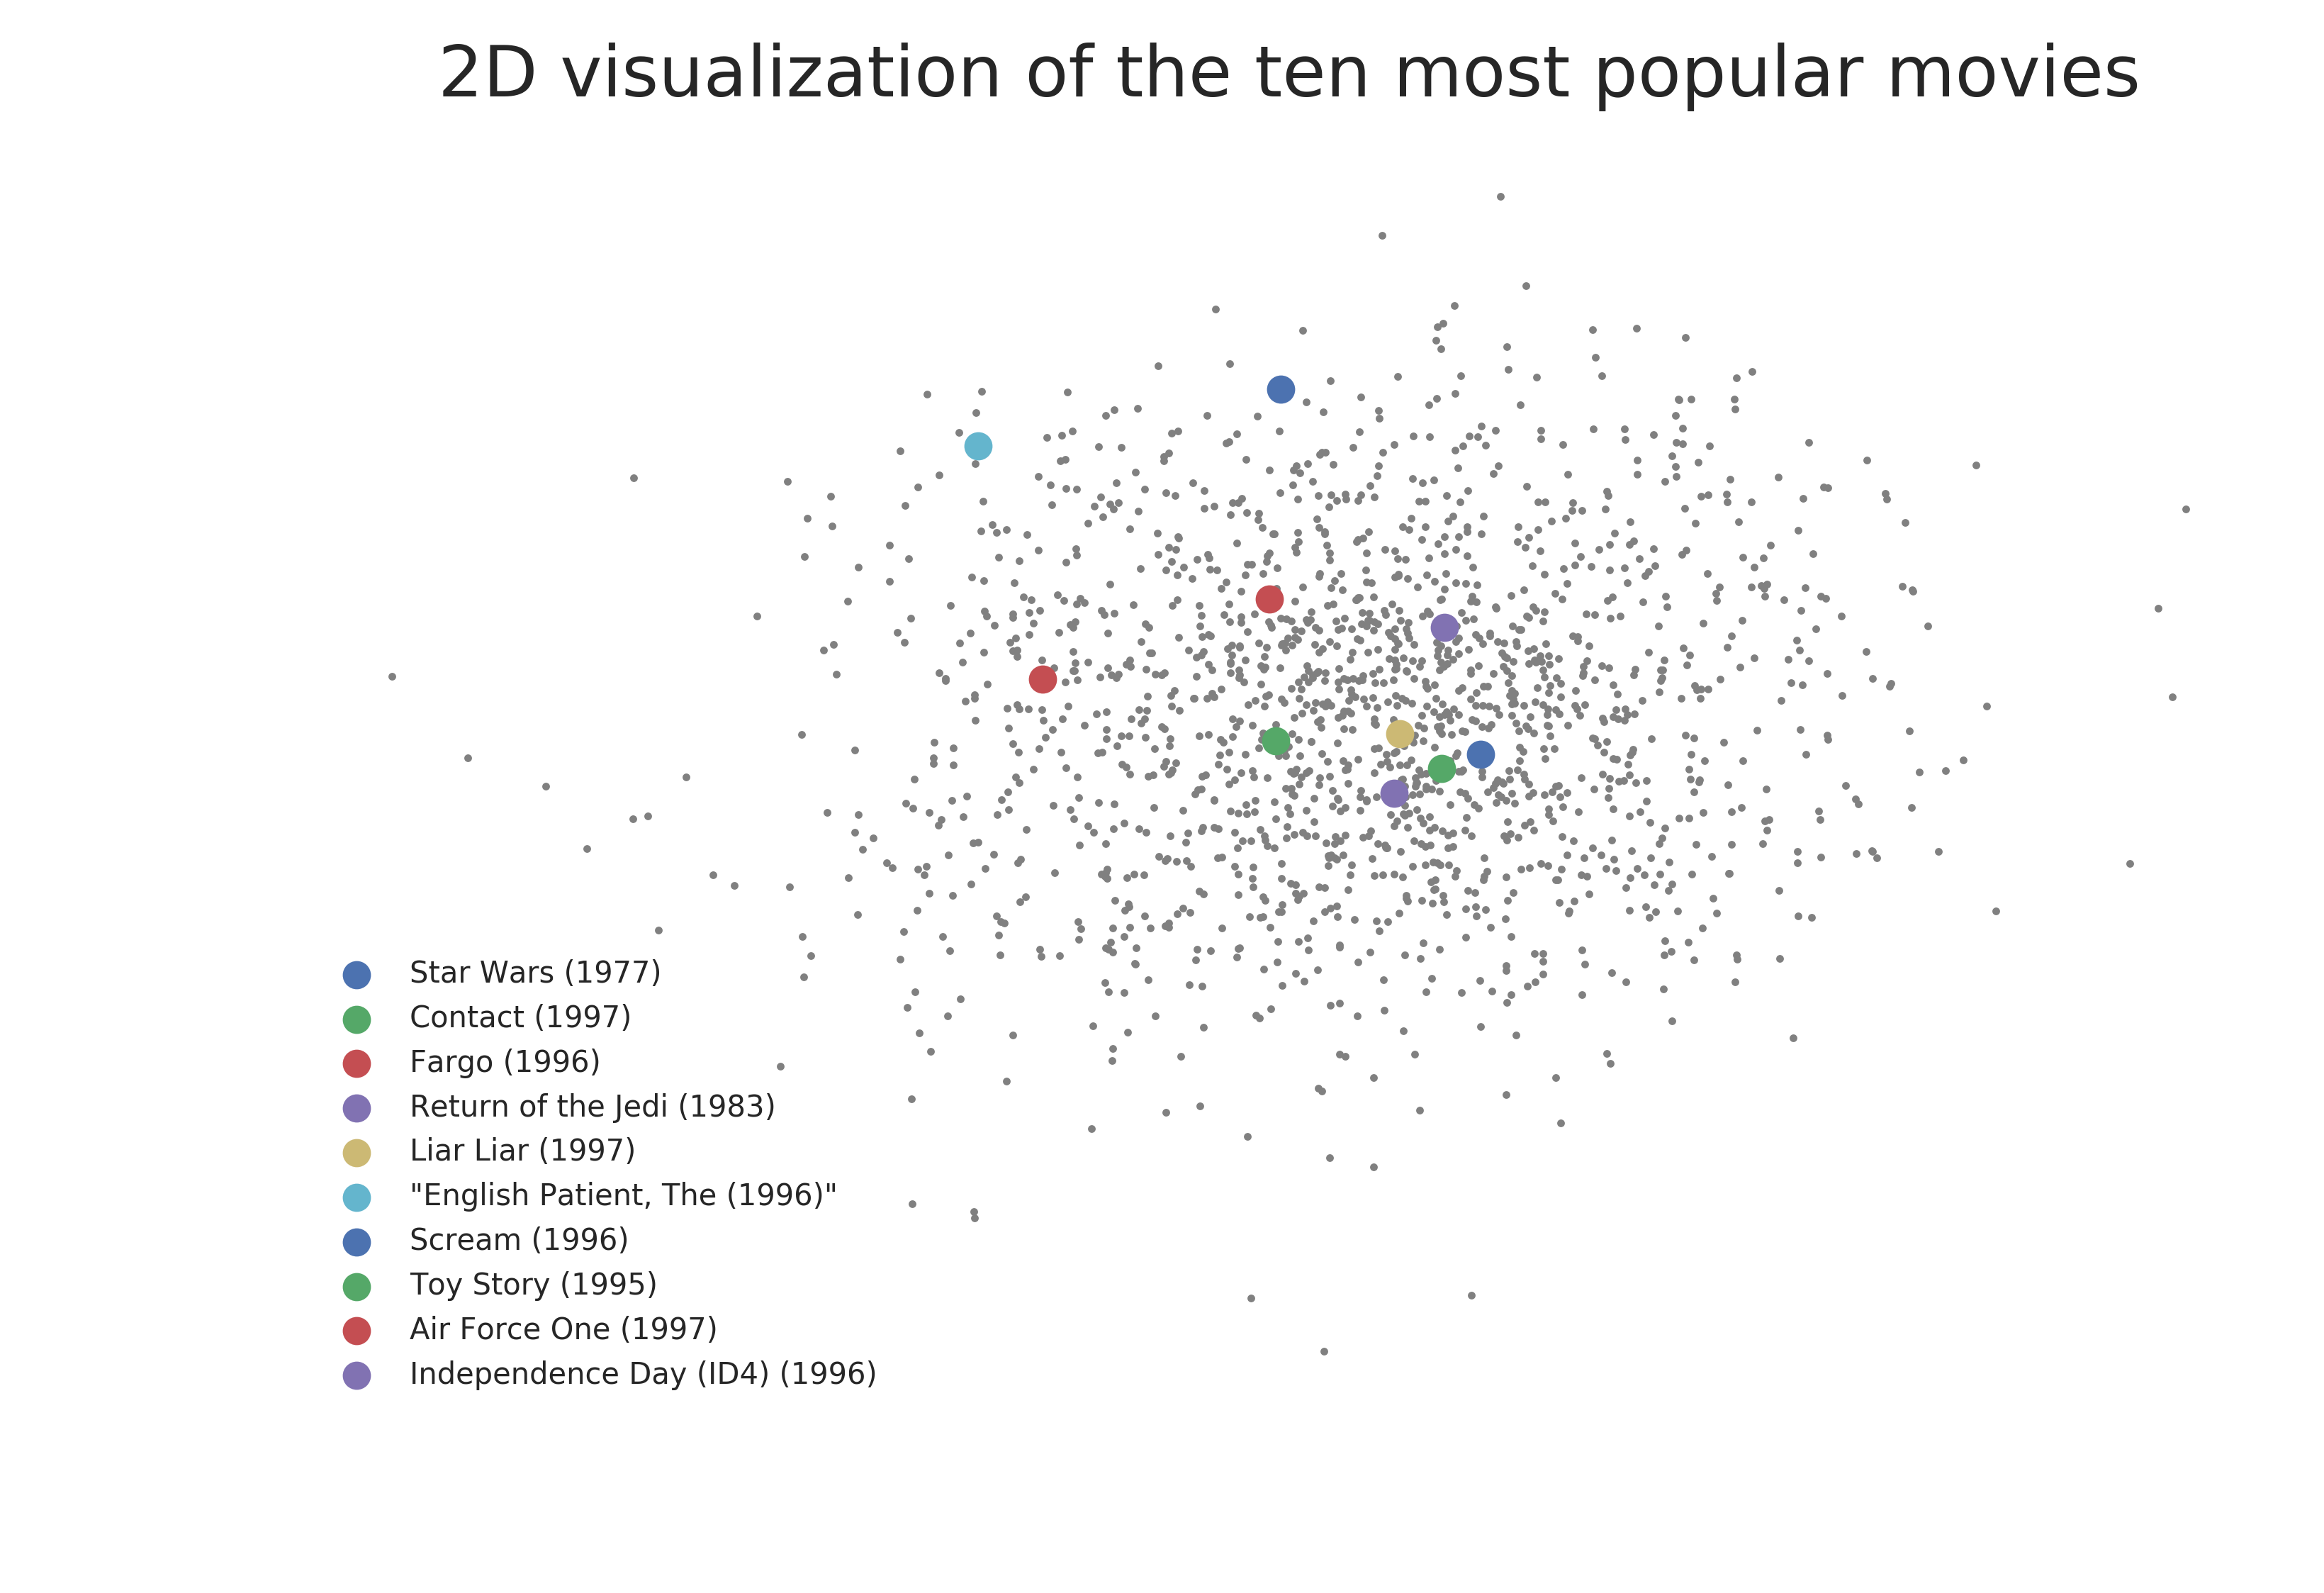

In [67]:
plt.figure(dpi=300)
plt.scatter(V_bias_transformed[0, :], V_bias_transformed[1, :], 1, 'gray')
for idx in rank_counts[:10]:
    plt.scatter(V_bias_transformed[0, idx], V_bias_transformed[1, idx], 20, label=movie_title[idx])
plt.axis('off')
plt.legend(prop={'size': 5})
plt.title('2D visualization of the ten most popular movies')
plt.show()

## c) Ten Best Movies

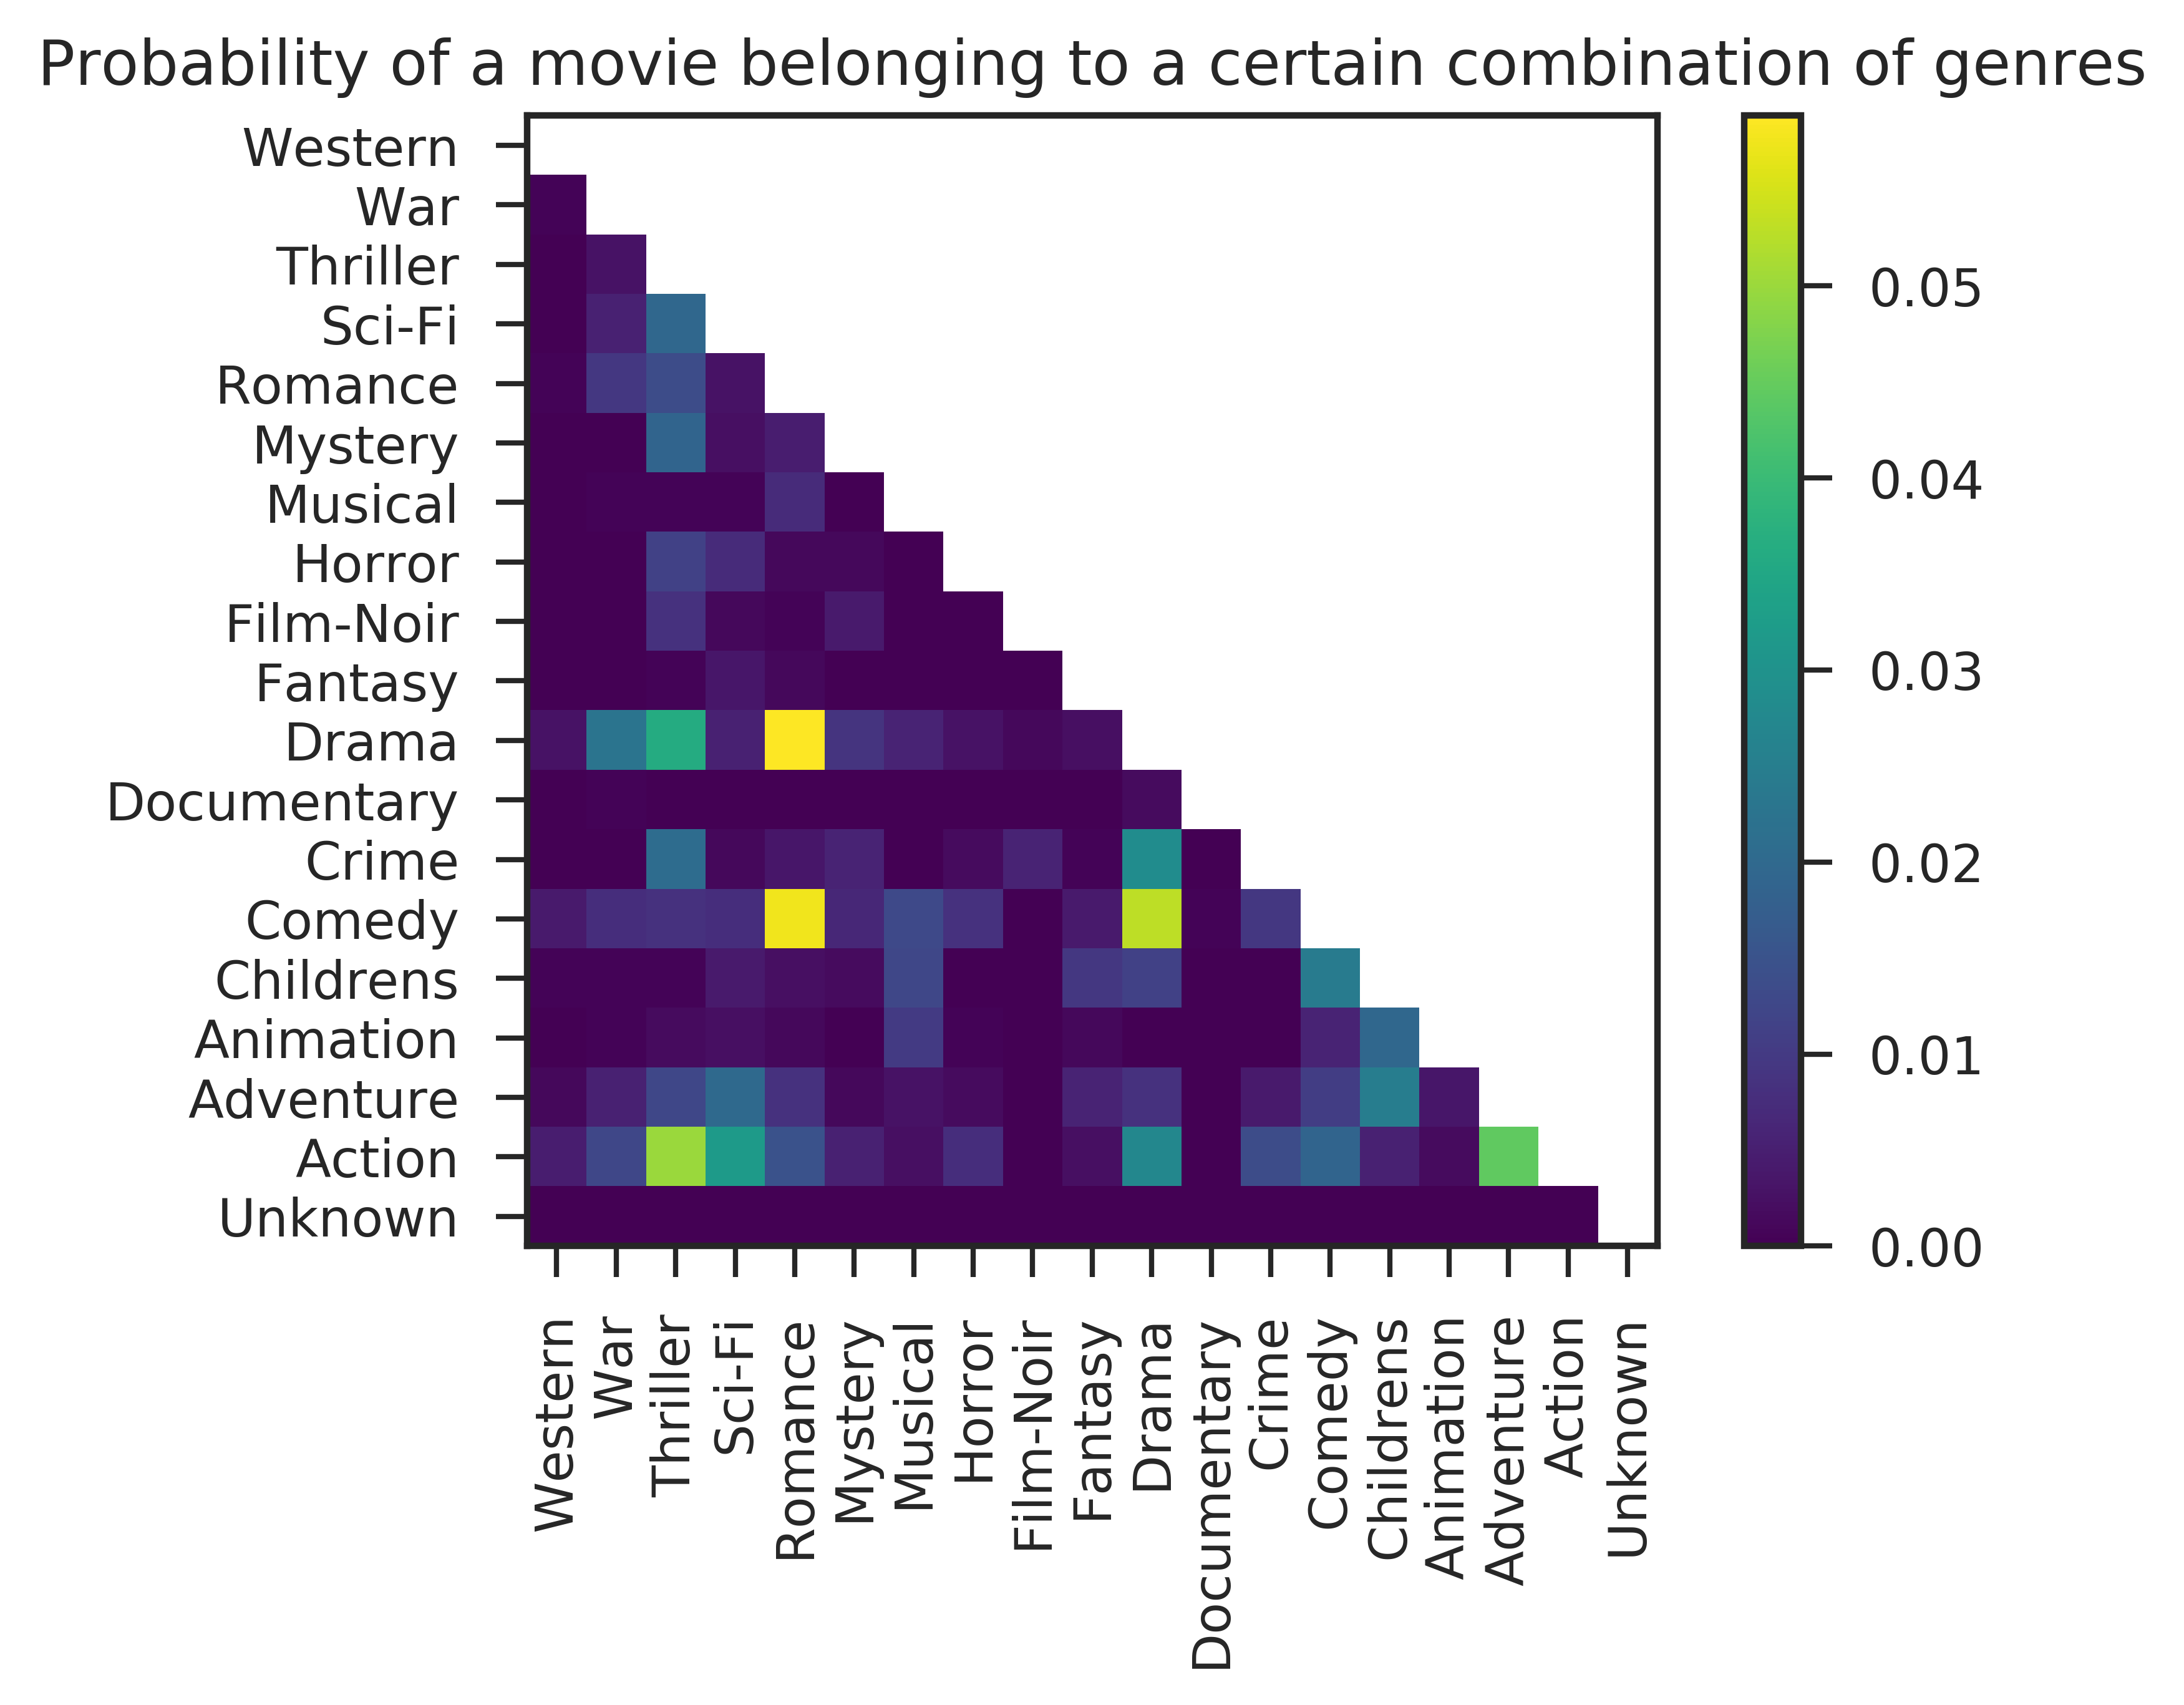

In [68]:
sns.set_style("ticks")
n_genres = len(genres)
genre_similarity_nodiag = genre_similarity.copy()
for i in range(n_genres):
    genre_similarity_nodiag[i, i] = np.nan
plt.figure(dpi=300)
plt.imshow(np.rot90(genre_similarity_nodiag, 2), extent=[0.5, n_genres+0.5, 0.5, n_genres+0.5],
          cmap='viridis')
plt.xticks(np.arange(n_genres)+1, genres[::-1], rotation='vertical')
plt.yticks(np.arange(n_genres)+1, genres)
plt.colorbar()
plt.title('Probability of a movie belonging to a certain combination of genres')
plt.show()

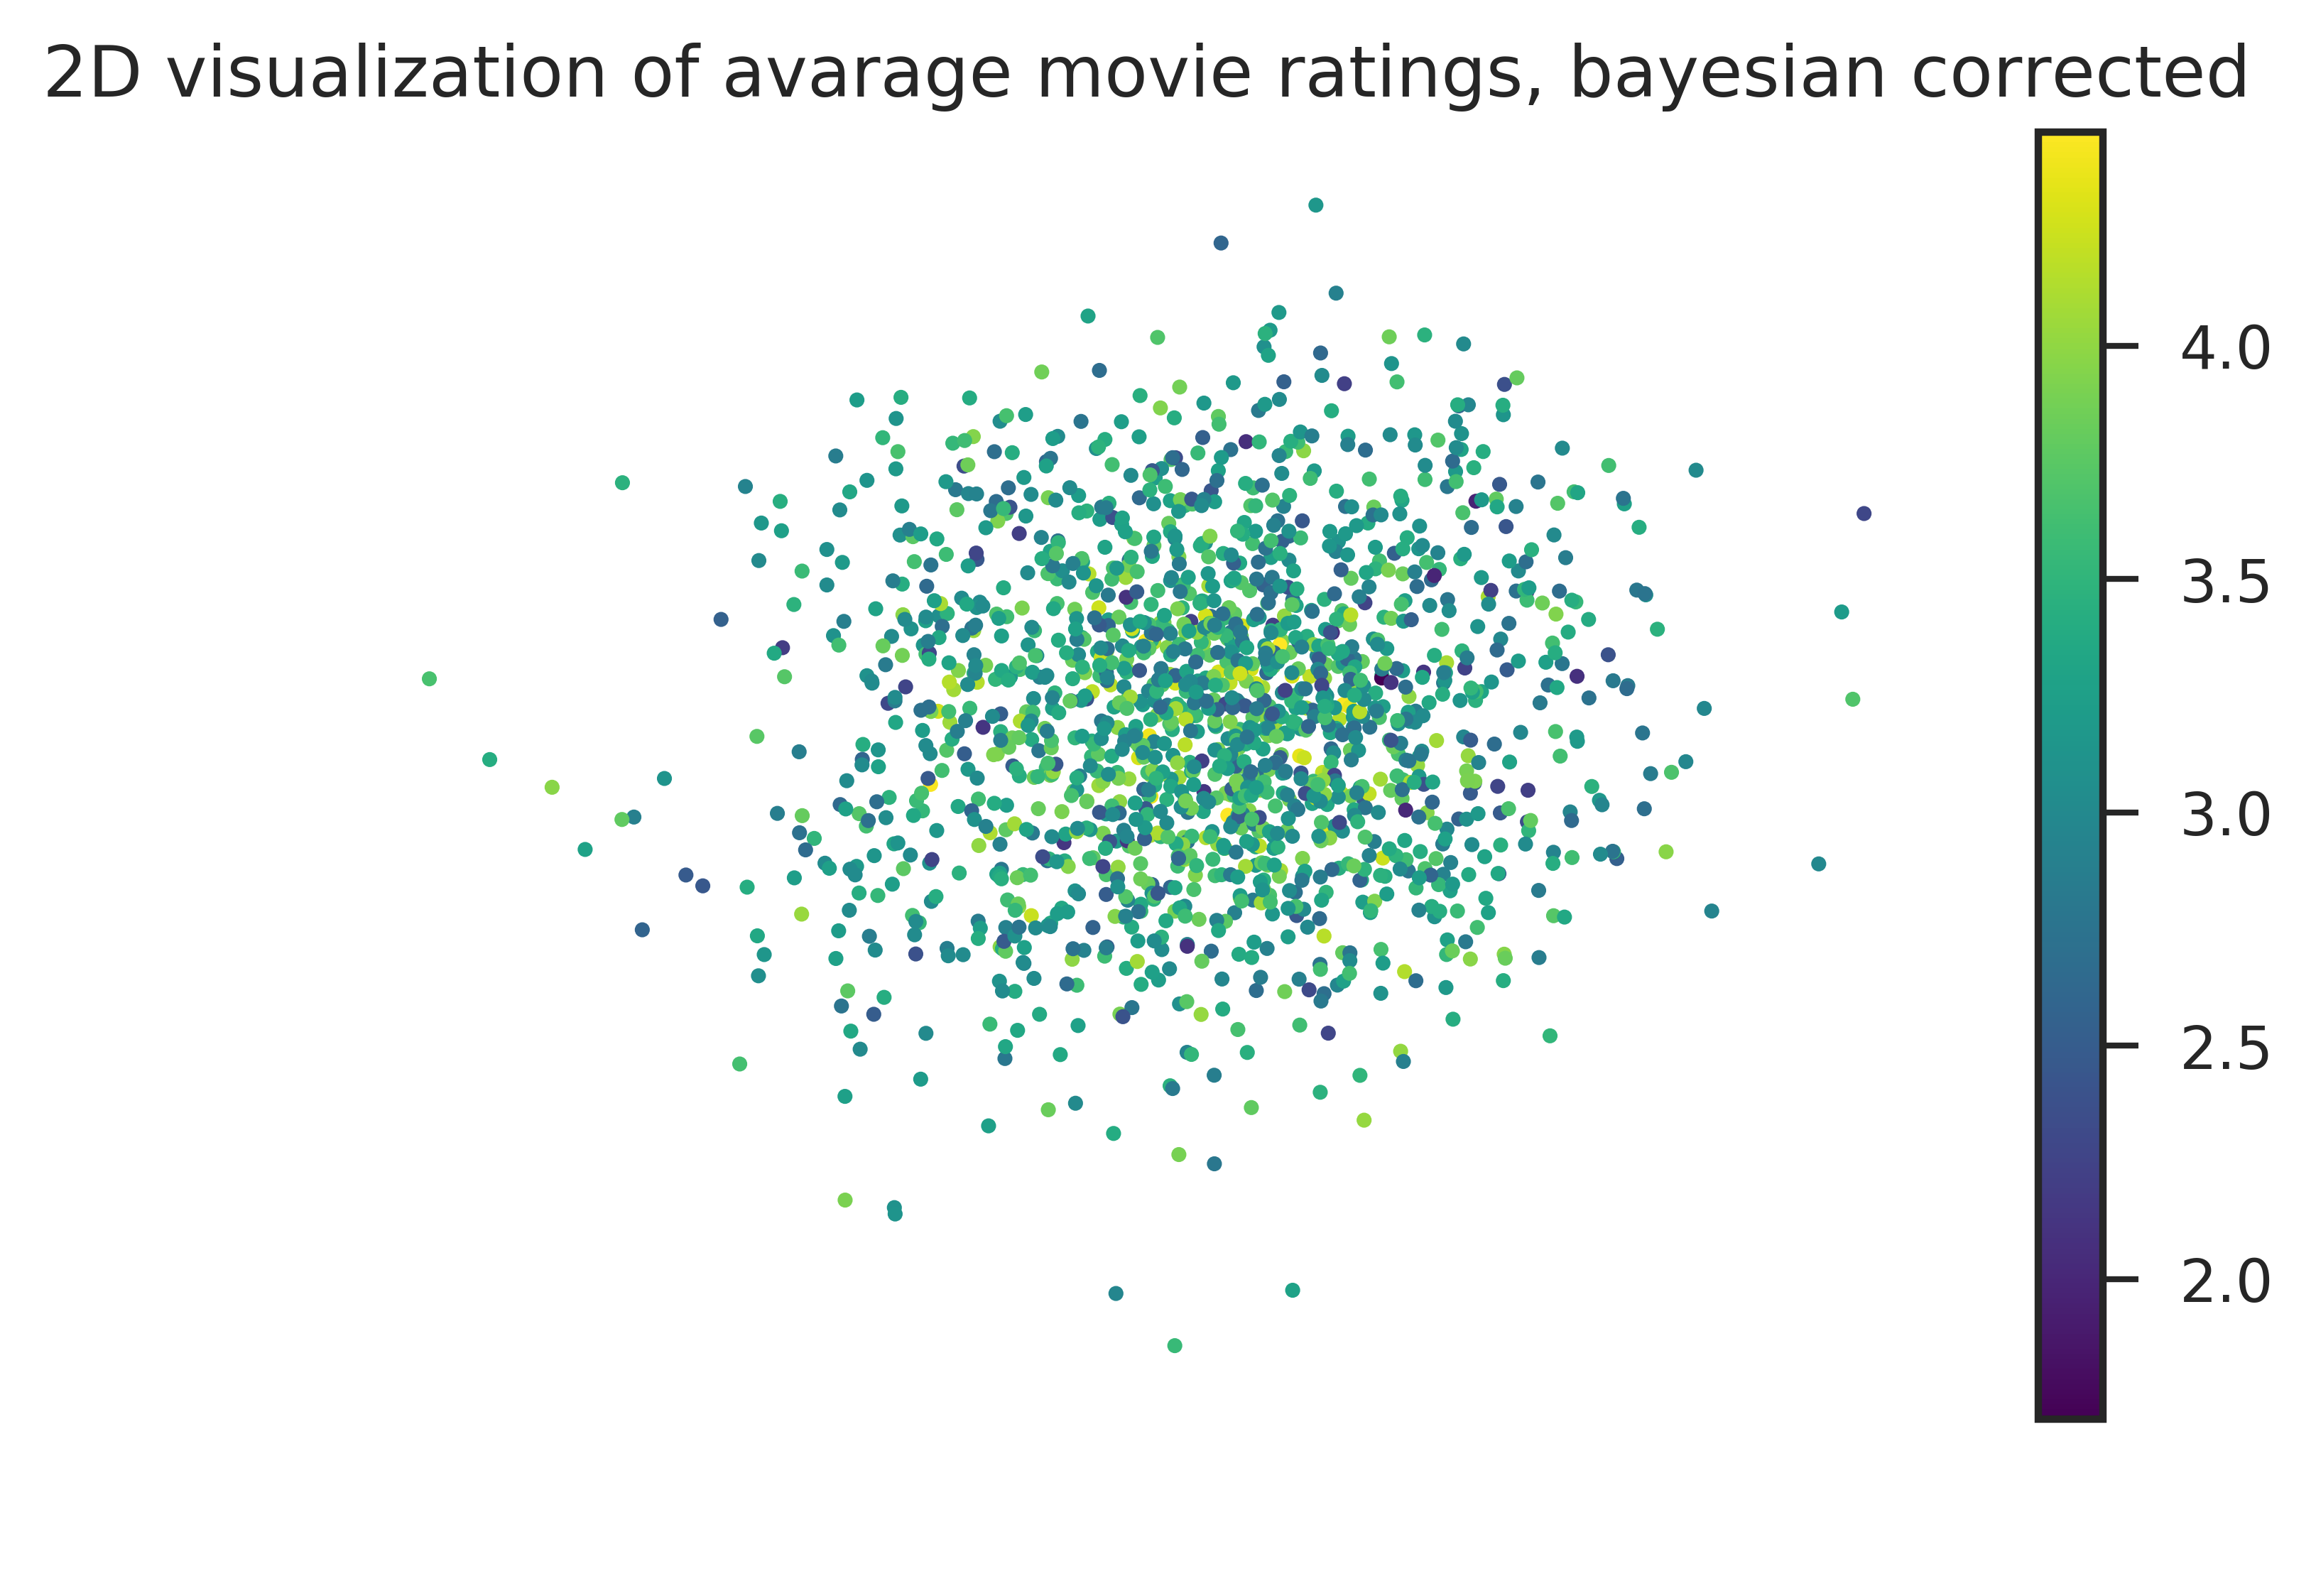

In [69]:
plt.figure(dpi=300)
plt.scatter(V_bias_transformed[0, :], V_bias_transformed[1, :], 5, ratings_bayesian, cmap='viridis')
plt.title('2D visualization of avarage movie ratings, bayesian corrected')
plt.colorbar()
plt.axis('off')
plt.show()

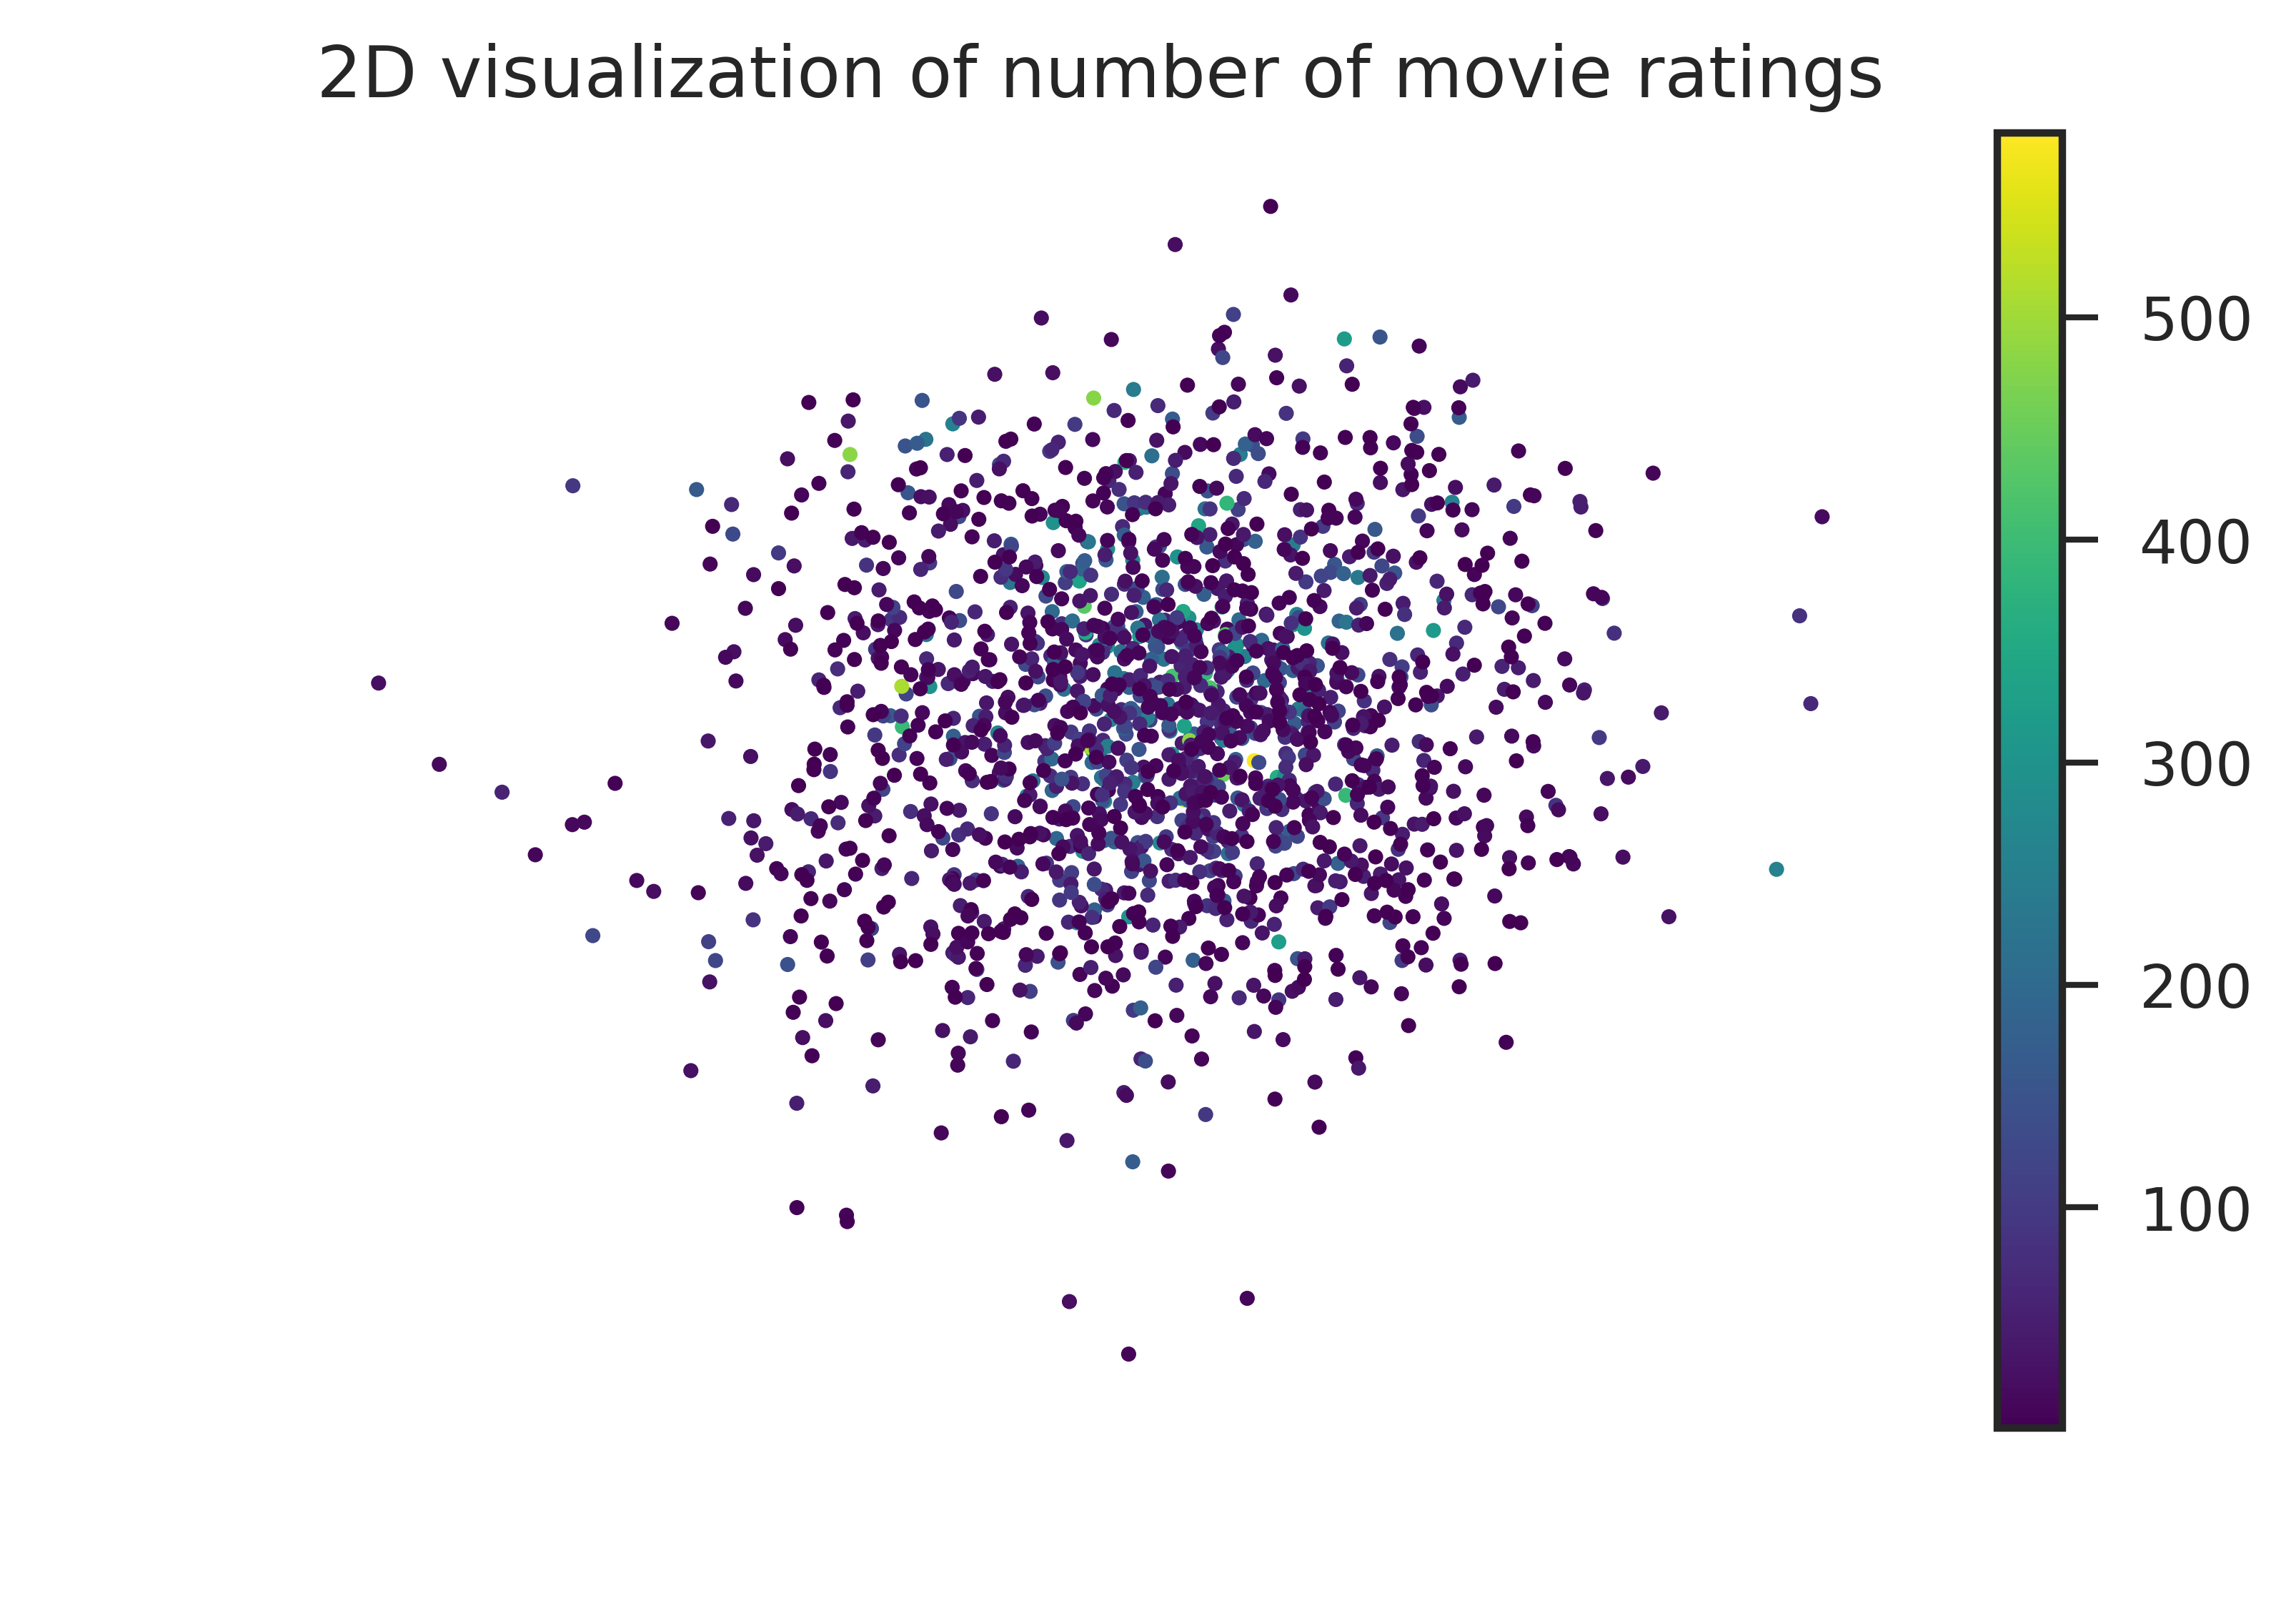

In [71]:
plt.figure(dpi=300)
plt.scatter(V_bias_transformed[0, :], V_bias_transformed[1, :], 5, counts, cmap='viridis')
plt.title('2D visualization of number of movie ratings')
plt.colorbar()
plt.axis('off')
plt.show()

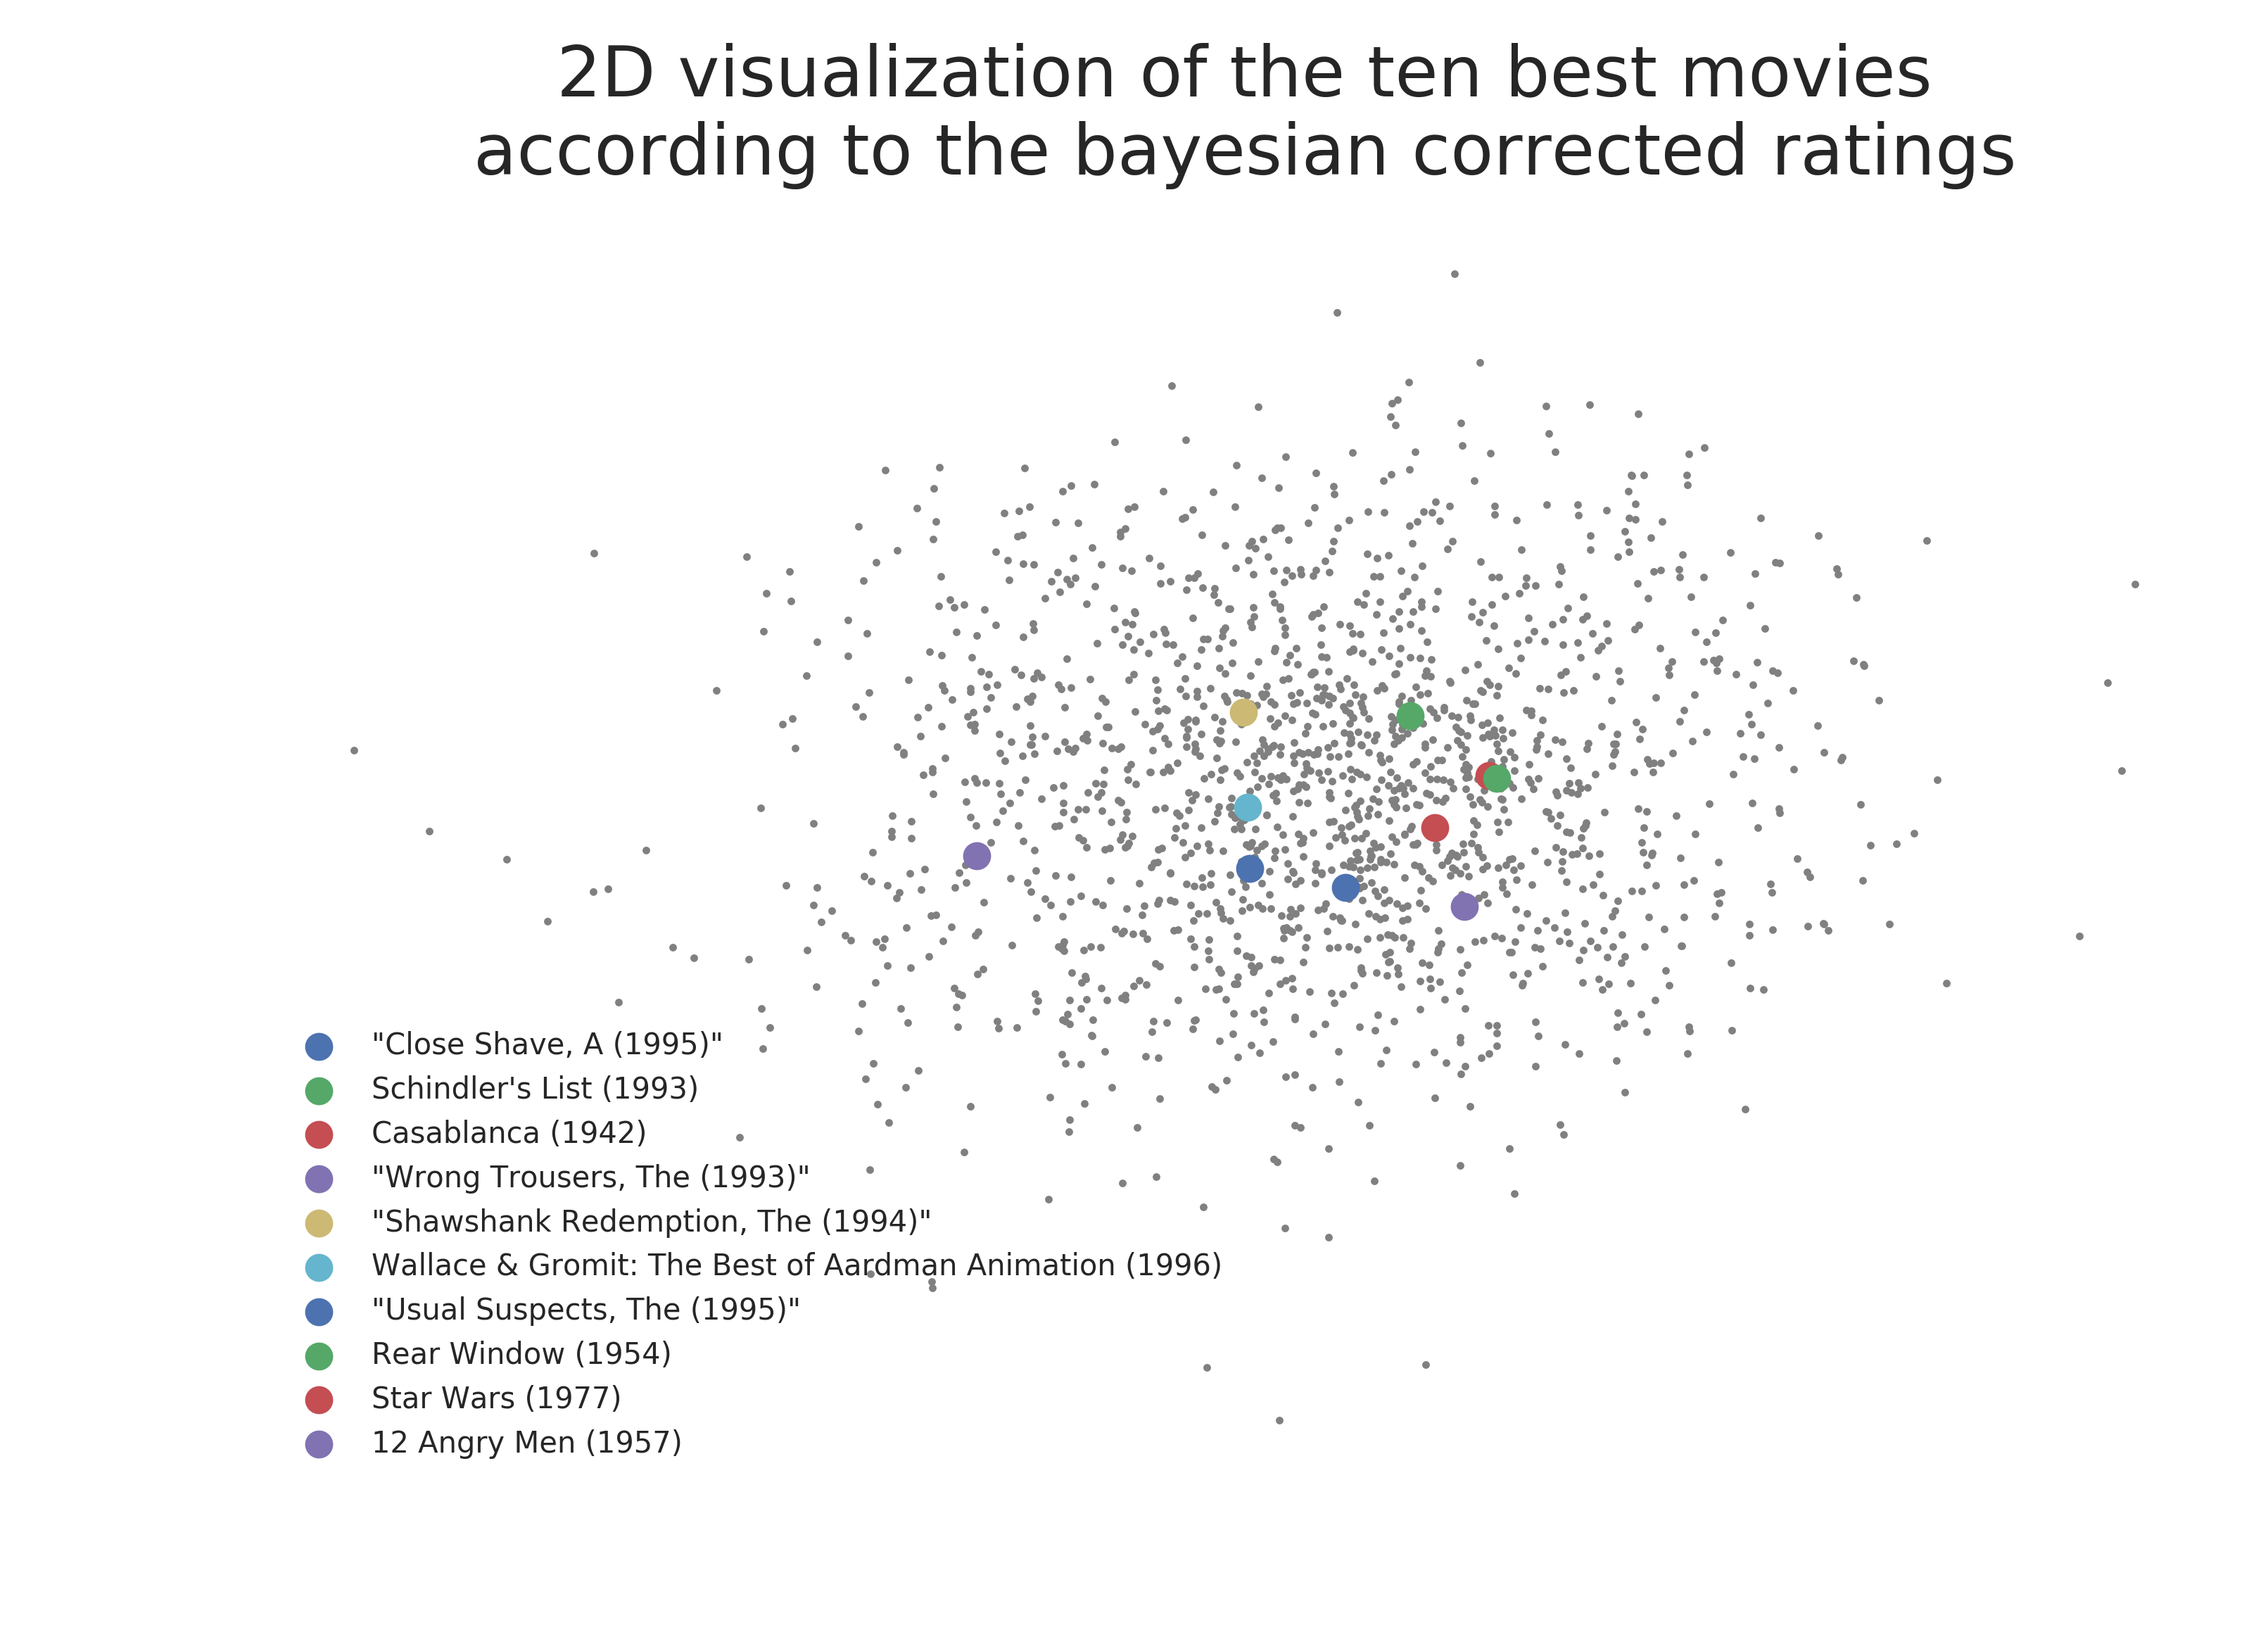

In [78]:
plt.figure(dpi=300)
plt.scatter(V_bias_transformed[0, :], V_bias_transformed[1, :], 1, 'gray')
for idx in rank_ratings_bayesian[:10]:
    plt.scatter(V_bias_transformed[0, idx], V_bias_transformed[1, idx], 20, label=movie_title[idx])
plt.axis('off')
plt.legend(prop={'size': 5})
plt.title('2D visualization of the ten best movies\naccording to the bayesian corrected ratings')
plt.show()

## Movies from 3 genres

In [136]:
def get_random_genre_projection_plot(genre, title):
    
    genre_movie_ids = movie_id[np.where(movie_genre[:, np.where(genres == genre)[0][0]] == 1)] - 1
    genre_movie_ids = np.random.choice(genre_movie_ids, 10)
    genre_movie_titles = movie_title[genre_movie_ids]

    plot = get_custom_movie_projection_plot(V_bias_transformed[:, genre_movie_ids], genre_movie_titles, "%s %s" % (title, genre), size=800)
    return plot

plot = get_random_genre_projection_plot("Childrens", "Biased SVD Projection")
show(plot)

In [137]:
plot = get_random_genre_projection_plot("War", "Biased SVD Projection")
show(plot)

In [138]:
plot = get_random_genre_projection_plot("Comedy", "Biased SVD Projection")
show(plot)